In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from utils import *
from preprocessing import *
from visualization import *
from feature_selectors.categorical_feature_selectors import MutualInformationSelector
from feature_selectors.correlation_feature_selector import CorrelationFeatureSelector
from pathlib import Path

In [3]:
root_dir = Path("data").resolve()
filename = 'train.csv'

In [4]:
X  = read_data_from_csv(root_dir, filename).drop(columns=["Id"])
y = X["SalePrice"]

In [5]:
n_df = X[get_numeric_columns(X)]

In [6]:
for col in columns_with_nans(n_df).index:
    n_df = feature_fill_nan_with_value(n_df, col, n_df[col].mean())

In [7]:
n_df = CorrelationFeatureSelector(method='spearman', threshold=0.2).fit_transform(n_df, y)

In [8]:
n_df = n_df.drop(columns='SalePrice')

In [9]:
c_df = X[get_categorical_columns(X)]

In [10]:
c_df = fill_nan(c_df, "NA")

In [11]:
c_df = MutualInformationSelector(mi_threshold=0.1).fit_transform(c_df, y)

## Concat filtered features

In [12]:
# X_preprocessed, _ = normalize_data(pd.concat([n_df, c_df], axis=1).to_numpy())
X_preprocessed = pd.concat([n_df, c_df], axis=1).to_numpy()

In [13]:
X_train, X_test, y_train, y_test = split_data(X_preprocessed, log_transform(y), test_size=0.3, shuffle=True)
X_train, scalar = normalize_data(X_train)
X_test = scalar.transform(X_test)

In [14]:
from sklearn.dummy import DummyRegressor

In [15]:
dummy_model = DummyRegressor(strategy='mean').fit(X_train, y=y_train)

In [16]:
y_preds = dummy_model.predict(X_test)

In [17]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [18]:
print(mse, rmse, r2)

0.16990443027764138 0.412194650957095 -0.001535501621115376


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_with_error_shading(y_true, y_pred, ax=None):
    # Sort by true values for a cleaner plot (optional)
    if ax is None:
        fig, ax = plt.subplots()
    sorted_idx = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]

    ax.plot(y_true_sorted, label='Actual', color='red')
    ax.plot(y_pred_sorted, label='Predicted', color='blue')

    # Shaded area: absolute error
    ax.fill_between(range(len(y_true)), y_true_sorted, y_pred_sorted,
                     color='green', alpha=0.3, label='Error (Residual)')

    ax.set_title('Actual vs Predicted with Error Shading')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Target Value')
    ax.legend()
    ax.grid(True)


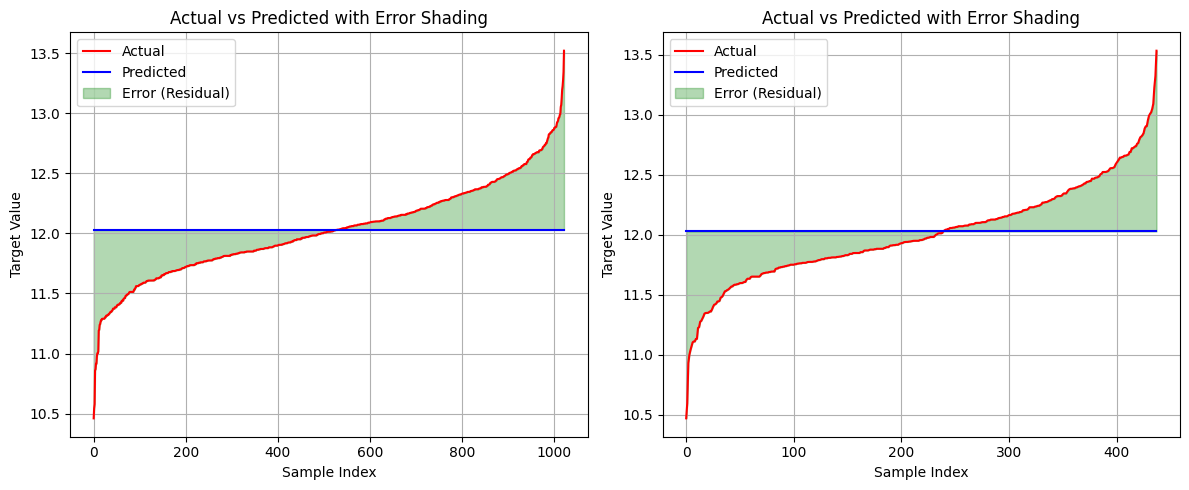

In [20]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, dummy_model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [21]:
from sklearn.svm import SVR

In [22]:
model = SVR(kernel='linear', C=0.001, max_iter=100000, epsilon=0.01)

In [23]:
model.fit(X_train, y_train)

SVR(C=0.001, epsilon=0.01, kernel='linear', max_iter=100000)

In [24]:
y_preds = model.predict(X_test)

In [25]:
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [26]:
print(mse, rmse, r2)

0.021348273841820385 0.14611048505093802 0.8741583482197982


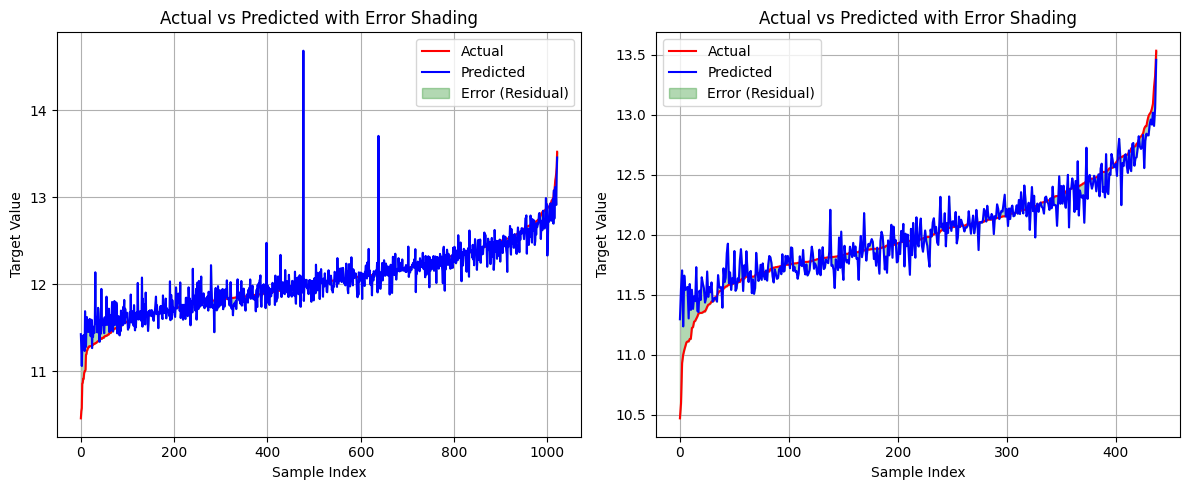

In [27]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=300,
                      random_state=42)

In [29]:
y_preds = rf.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [31]:
print(mse, rmse, r2)

0.020205445020303695 0.14214585825940795 0.8808949803085226


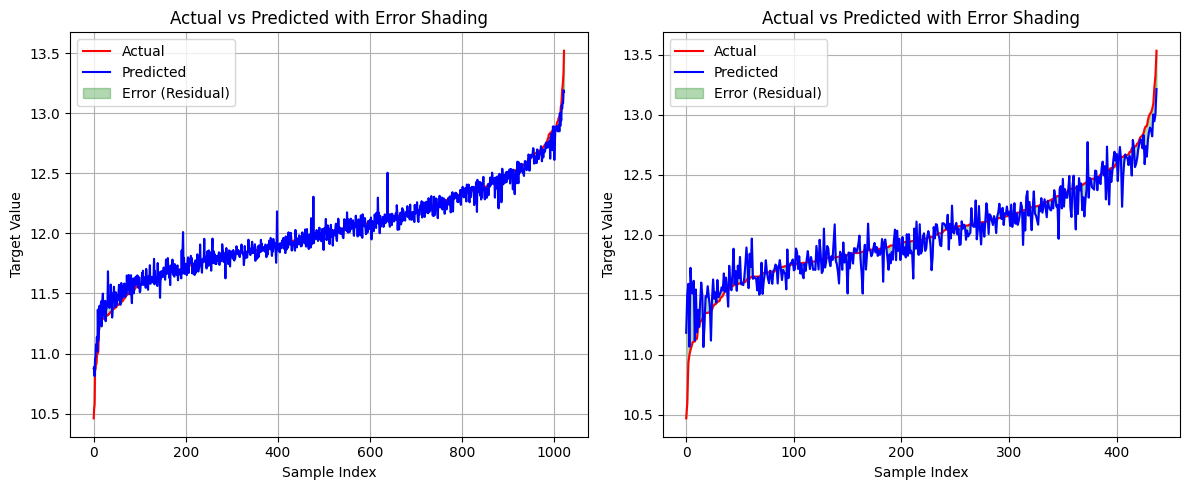

In [33]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, rf.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [34]:
# Or LightGBM
import lightgbm as lgb
model = lgb.LGBMRegressor(
    n_estimators=120,
    learning_rate=0.07,
    num_leaves=16,
    random_state=42
)


In [35]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 37
[LightGBM] [Info] Start training from score 12.028899


LGBMRegressor(learning_rate=0.07, n_estimators=120, num_leaves=16,
              random_state=42)

In [36]:
y_preds = model.predict(X_test)

c:\Users\mwaff\anaconda3\envs\kaggle_house\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [42]:
mse = mean_squared_error(y_test, model.predict(X_test))
rmse = root_mean_squared_error(y_test, model.predict(X_test))
r2  = r2_score(y_test, model.predict(X_test))

c:\Users\mwaff\anaconda3\envs\kaggle_house\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mwaff\anaconda3\envs\kaggle_house\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mwaff\anaconda3\envs\kaggle_house\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [43]:
print(mse, rmse, r2)

0.020877214815430308 0.14448949724955898 0.8769350994647057


c:\Users\mwaff\anaconda3\envs\kaggle_house\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


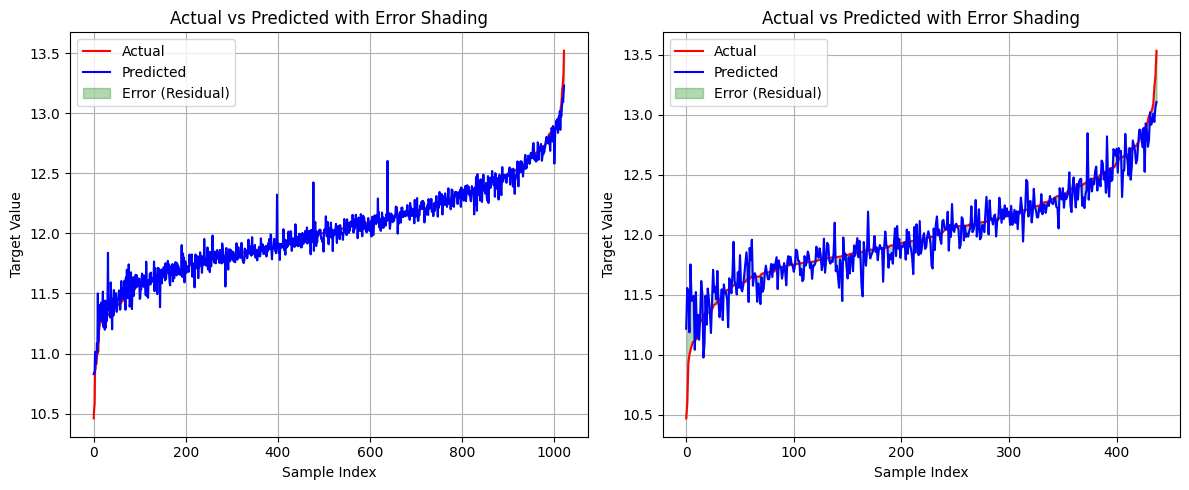

In [44]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()